In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/twolink/'

In [5]:
# data_train = np.load(savepath+'data_pd_noreg.npy')
# task = TwoLinkReaching(render=True)
# task.visualize_training_data(data_train, 0)

In [6]:
task = TwoLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100*torch.ones_like(q_lb), 100*torch.ones_like(q_ub)

In [7]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD

# na = 2
# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)
# actor = Actor(na, Identity(nq, nv, nu), action_lb, action_ub)

na = 4
gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(PD(nx, nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor 

In [8]:
# # Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nx, nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size,
                                 learning_rate = 0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [9]:
# Setup controller

from stage.controllers.pets import PETS

plan_horizon = 60
n_particles = 10
pop_size = 400

controller = PETS(dynamics, task.cost, actor,
                  plan_horizon, n_particles, pop_size)

In [10]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller, epochs, batch_size)

In [11]:
lip_reg = False

if lip_reg:
    controller.regularize(1)
    file_name = savepath + 'data_pd_reg'
else: 
    controller.regularize(0)
    file_name = savepath + 'data_pd_noreg'
    
_ = learner.learn(50, verbose=True)
learner.save_training_data(file_name)

Network training: 100%|██████████| 10/10 [00:00<00:00, 23.89epoch(s)/s, Training loss MSE=1.737472]


Iteration:  0
Initial state:  tensor([2.3238, 0.1894, 0.0000, 0.0000])
avg. decision time:  0.012502596378326417
obs. reward:  -646.62756
act. reward:  -2.9207406


Network training: 100%|██████████| 10/10 [00:00<00:00, 13.96epoch(s)/s, Training loss MSE=0.6902512]


Iteration:  1
Initial state:  tensor([2.4078, 0.0383, 0.0000, 0.0000])
avg. decision time:  0.497767733335495
obs. reward:  -742.0065
act. reward:  -0.1244108


Network training: 100%|██████████| 10/10 [00:01<00:00,  9.80epoch(s)/s, Training loss MSE=0.42823216]


Iteration:  2
Initial state:  tensor([2.3215, 0.0526, 0.0000, 0.0000])
avg. decision time:  0.5024127745628357
obs. reward:  -448.40225
act. reward:  -0.5821177


Network training: 100%|██████████| 10/10 [00:01<00:00,  7.67epoch(s)/s, Training loss MSE=0.37683216]


Iteration:  3
Initial state:  tensor([2.2679, 0.1671, 0.0000, 0.0000])
avg. decision time:  0.4986127996444702
obs. reward:  -430.64508
act. reward:  -0.7998982


Network training: 100%|██████████| 10/10 [00:01<00:00,  6.20epoch(s)/s, Training loss MSE=0.32440892]


Iteration:  4
Initial state:  tensor([ 2.1704, -0.0455,  0.0000,  0.0000])
avg. decision time:  0.5005011641979218
obs. reward:  -704.62787
act. reward:  -0.8381221


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.27epoch(s)/s, Training loss MSE=0.3893588]


Iteration:  5
Initial state:  tensor([ 2.4084, -0.1770,  0.0000,  0.0000])
avg. decision time:  0.5056565117835998
obs. reward:  -1059.9243
act. reward:  -1.8184538


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.50epoch(s)/s, Training loss MSE=0.38642305]


Iteration:  6
Initial state:  tensor([ 2.3660, -0.0665,  0.0000,  0.0000])
avg. decision time:  0.5004745614528656
obs. reward:  -1063.0032
act. reward:  -1.023588


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.94epoch(s)/s, Training loss MSE=0.37573212]


Iteration:  7
Initial state:  tensor([ 2.1594, -0.0657,  0.0000,  0.0000])
avg. decision time:  0.4996828532218933
obs. reward:  -1062.2617
act. reward:  -0.50777173


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.42epoch(s)/s, Training loss MSE=0.39797825]


Iteration:  8
Initial state:  tensor([ 2.4604, -0.0864,  0.0000,  0.0000])
avg. decision time:  0.5005423021316528
obs. reward:  -1328.4199
act. reward:  -3.1640732


Network training: 100%|██████████| 10/10 [00:03<00:00,  3.10epoch(s)/s, Training loss MSE=0.36220366]


Iteration:  9
Initial state:  tensor([2.3971, 0.0877, 0.0000, 0.0000])
avg. decision time:  0.5025114762783051
obs. reward:  -1192.1179
act. reward:  -0.09410175


Network training: 100%|██████████| 10/10 [00:03<00:00,  3.23epoch(s)/s, Training loss MSE=0.36822423]


Iteration:  10
Initial state:  tensor([2.4366, 0.1410, 0.0000, 0.0000])
avg. decision time:  0.5056500101089477
obs. reward:  -1417.1727
act. reward:  -1.9946504


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.63epoch(s)/s, Training loss MSE=0.37203872]


Iteration:  11
Initial state:  tensor([2.3008, 0.0184, 0.0000, 0.0000])
avg. decision time:  0.5062223088741302
obs. reward:  -1233.3704
act. reward:  -3.3241925


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.40epoch(s)/s, Training loss MSE=0.443926] 


Iteration:  12
Initial state:  tensor([2.2589, 0.0405, 0.0000, 0.0000])
avg. decision time:  0.5042524421215058
obs. reward:  -1202.5039
act. reward:  -1.8147218


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.30epoch(s)/s, Training loss MSE=0.3880076]


Iteration:  13
Initial state:  tensor([ 2.3433, -0.0577,  0.0000,  0.0000])
avg. decision time:  0.5040092527866363
obs. reward:  -1240.0404
act. reward:  -3.418895


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.16epoch(s)/s, Training loss MSE=0.38560444]


Iteration:  14
Initial state:  tensor([2.3788, 0.0802, 0.0000, 0.0000])
avg. decision time:  0.5084889101982116
obs. reward:  -1135.3105
act. reward:  -2.064845


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.01epoch(s)/s, Training loss MSE=0.37724274]


Iteration:  15
Initial state:  tensor([2.3622, 0.0999, 0.0000, 0.0000])
avg. decision time:  0.5067744696140289
obs. reward:  -1149.7291
act. reward:  -2.6661506


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.13epoch(s)/s, Training loss MSE=0.3499427]


Iteration:  16
Initial state:  tensor([2.4372, 0.0925, 0.0000, 0.0000])
avg. decision time:  0.5036028730869293
obs. reward:  -479.74823
act. reward:  -0.3990927


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.75epoch(s)/s, Training loss MSE=0.3312959]


Iteration:  17
Initial state:  tensor([2.3749, 0.0546, 0.0000, 0.0000])
avg. decision time:  0.5063985812664032
obs. reward:  -674.1701
act. reward:  -0.70802116


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.67epoch(s)/s, Training loss MSE=0.30326203]


Iteration:  18
Initial state:  tensor([2.4060, 0.0725, 0.0000, 0.0000])
avg. decision time:  0.505988953113556
obs. reward:  -741.8968
act. reward:  -1.8311496


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.58epoch(s)/s, Training loss MSE=0.2869278]


Iteration:  19
Initial state:  tensor([ 2.2754, -0.1222,  0.0000,  0.0000])
avg. decision time:  0.5397396683692932
obs. reward:  -458.13757
act. reward:  -0.83408254


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.52epoch(s)/s, Training loss MSE=0.2843983]


Iteration:  20
Initial state:  tensor([ 2.3462, -0.0468,  0.0000,  0.0000])
avg. decision time:  0.504346935749054
obs. reward:  -686.0397
act. reward:  -0.51534355


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.45epoch(s)/s, Training loss MSE=0.28684738]


Iteration:  21
Initial state:  tensor([2.3430, 0.1358, 0.0000, 0.0000])
avg. decision time:  0.5096986305713653
obs. reward:  -629.93866
act. reward:  -0.81944263


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.39epoch(s)/s, Training loss MSE=0.25875926]


Iteration:  22
Initial state:  tensor([ 2.2957, -0.1775,  0.0000,  0.0000])
avg. decision time:  0.507069753408432
obs. reward:  -972.667
act. reward:  -0.22430456


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.33epoch(s)/s, Training loss MSE=0.25247377]


Iteration:  23
Initial state:  tensor([ 2.3861, -0.1865,  0.0000,  0.0000])
avg. decision time:  0.5064305830001831
obs. reward:  -761.5799
act. reward:  -0.7204616


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.30epoch(s)/s, Training loss MSE=0.2879883]


Iteration:  24
Initial state:  tensor([ 2.4368, -0.0072,  0.0000,  0.0000])
avg. decision time:  0.5050275564193726
obs. reward:  -673.6788
act. reward:  -0.71958154


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.21epoch(s)/s, Training loss MSE=0.24075955]


Iteration:  25
Initial state:  tensor([ 2.3898, -0.0220,  0.0000,  0.0000])
avg. decision time:  0.5079903292655945
obs. reward:  -675.19183
act. reward:  -3.454265


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.17epoch(s)/s, Training loss MSE=0.23707488]


Iteration:  26
Initial state:  tensor([ 2.2728, -0.1735,  0.0000,  0.0000])
avg. decision time:  0.510124808549881
obs. reward:  -570.92896
act. reward:  -1.6248062


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.13epoch(s)/s, Training loss MSE=0.2190662]


Iteration:  27
Initial state:  tensor([2.2392, 0.0166, 0.0000, 0.0000])
avg. decision time:  0.5064969110488892
obs. reward:  -523.6816
act. reward:  -0.8522693


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.10epoch(s)/s, Training loss MSE=0.22192414]


Iteration:  28
Initial state:  tensor([2.2820, 0.1962, 0.0000, 0.0000])
avg. decision time:  0.5066760098934173
obs. reward:  -603.0829
act. reward:  -0.9177155


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.06epoch(s)/s, Training loss MSE=0.19142458]


Iteration:  29
Initial state:  tensor([2.4873, 0.0676, 0.0000, 0.0000])
avg. decision time:  0.505198415517807
obs. reward:  -543.44104
act. reward:  -1.3424388


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.06epoch(s)/s, Training loss MSE=0.19773613]


Iteration:  30
Initial state:  tensor([2.1985, 0.0700, 0.0000, 0.0000])
avg. decision time:  0.5068971920013428
obs. reward:  -536.5696
act. reward:  -0.34899434


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.01s/epoch(s), Training loss MSE=0.23803532]


Iteration:  31
Initial state:  tensor([ 2.3099, -0.0462,  0.0000,  0.0000])
avg. decision time:  0.5040479719638824
obs. reward:  -672.6401
act. reward:  -0.71453416


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.03s/epoch(s), Training loss MSE=0.19090351]


Iteration:  32
Initial state:  tensor([2.3233, 0.0545, 0.0000, 0.0000])
avg. decision time:  0.507849851846695
obs. reward:  -604.4017
act. reward:  -0.72804296


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.07s/epoch(s), Training loss MSE=0.19978938]


Iteration:  33
Initial state:  tensor([ 2.3948, -0.1103,  0.0000,  0.0000])
avg. decision time:  0.5063601863384247
obs. reward:  -544.4286
act. reward:  -1.1005385


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.11s/epoch(s), Training loss MSE=0.1984215]


Iteration:  34
Initial state:  tensor([2.3261, 0.1297, 0.0000, 0.0000])
avg. decision time:  0.505122721195221
obs. reward:  -641.7308
act. reward:  -0.8316897


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.14s/epoch(s), Training loss MSE=0.1704621]


Iteration:  35
Initial state:  tensor([2.3271, 0.1955, 0.0000, 0.0000])
avg. decision time:  0.5070228481292725
obs. reward:  -670.6859
act. reward:  -0.69290376


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.17s/epoch(s), Training loss MSE=0.17438939]


Iteration:  36
Initial state:  tensor([ 2.4028, -0.0079,  0.0000,  0.0000])
avg. decision time:  0.5093276035785675
obs. reward:  -650.5068
act. reward:  -0.94563836


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.20s/epoch(s), Training loss MSE=0.16621438]


Iteration:  37
Initial state:  tensor([2.3124, 0.0660, 0.0000, 0.0000])
avg. decision time:  0.508358268737793
obs. reward:  -745.7668
act. reward:  -0.62679285


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.22s/epoch(s), Training loss MSE=0.1757145]


Iteration:  38
Initial state:  tensor([ 2.3818, -0.1065,  0.0000,  0.0000])
avg. decision time:  0.5079822504520416
obs. reward:  -879.0801
act. reward:  -1.305404


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.26s/epoch(s), Training loss MSE=0.16788916]


Iteration:  39
Initial state:  tensor([ 2.3481, -0.1380,  0.0000,  0.0000])
avg. decision time:  0.5094081127643585
obs. reward:  -801.83777
act. reward:  -0.7678723


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.30s/epoch(s), Training loss MSE=0.17079774]


Iteration:  40
Initial state:  tensor([ 2.4394, -0.0103,  0.0000,  0.0000])
avg. decision time:  0.5061039817333222
obs. reward:  -704.2376
act. reward:  -0.5727854


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.33s/epoch(s), Training loss MSE=0.1537704]


Iteration:  41
Initial state:  tensor([ 2.2596, -0.0851,  0.0000,  0.0000])
avg. decision time:  0.5096692144870758
obs. reward:  -141.64221
act. reward:  -1.3959776


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.35s/epoch(s), Training loss MSE=0.15278044]


Iteration:  42
Initial state:  tensor([ 2.3142, -0.1784,  0.0000,  0.0000])
avg. decision time:  0.5076521289348602
obs. reward:  -528.71423
act. reward:  -0.2781799


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.39s/epoch(s), Training loss MSE=0.17178753]


Iteration:  43
Initial state:  tensor([2.4900, 0.0609, 0.0000, 0.0000])
avg. decision time:  0.5050126445293427
obs. reward:  -602.7655
act. reward:  -0.63584554


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.40s/epoch(s), Training loss MSE=0.1484575]


Iteration:  44
Initial state:  tensor([2.3879, 0.1532, 0.0000, 0.0000])
avg. decision time:  0.5065346884727479
obs. reward:  -157.3458
act. reward:  -1.2352535


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.45s/epoch(s), Training loss MSE=0.16842285]


Iteration:  45
Initial state:  tensor([ 2.4181, -0.2661,  0.0000,  0.0000])
avg. decision time:  0.5087068259716034
obs. reward:  -1179.5386
act. reward:  -0.3079763


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.48s/epoch(s), Training loss MSE=0.12958957]


Iteration:  46
Initial state:  tensor([2.4144, 0.0833, 0.0000, 0.0000])
avg. decision time:  0.505882842540741
obs. reward:  -148.28593
act. reward:  -1.5627843


Network training: 100%|██████████| 10/10 [00:14<00:00,  1.49s/epoch(s), Training loss MSE=0.16214037]


Iteration:  47
Initial state:  tensor([2.3678, 0.1371, 0.0000, 0.0000])
avg. decision time:  0.5053183507919311
obs. reward:  -152.26236
act. reward:  -1.622561


Network training: 100%|██████████| 10/10 [00:15<00:00,  1.55s/epoch(s), Training loss MSE=0.14985862]


Iteration:  48
Initial state:  tensor([ 2.2674, -0.0349,  0.0000,  0.0000])
avg. decision time:  0.5087462902069092
obs. reward:  -129.0957
act. reward:  -1.4902879


Network training: 100%|██████████| 10/10 [00:15<00:00,  1.55s/epoch(s), Training loss MSE=0.13727263]

Iteration:  49
Initial state:  tensor([2.5383, 0.0680, 0.0000, 0.0000])
avg. decision time:  0.508720098733902
obs. reward:  -154.42908
act. reward:  -1.7641687


In [12]:
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.5099508666992187
obs. reward:  -134.84758
act. reward:  -1.7009422


In [13]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(0.1334, grad_fn=<MeanBackward0>)
tensor(0.0628, grad_fn=<StdBackward0>)


In [14]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [15]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [16]:
# traj_pred_mean = np.load('traj_pred_mean.npy')
# traj_pred_std = np.load('traj_pred_std.npy')
# traj = np.load('traj.npy')

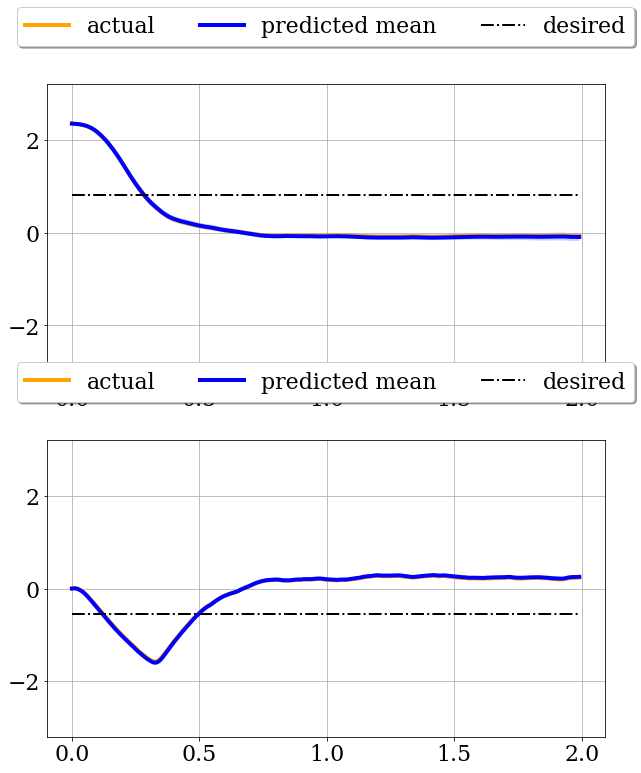

In [17]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
    _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')